<a href="https://colab.research.google.com/github/sean-otoole/HODD/blob/main/PDTx_pipeline/PDTx_03_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# downgrade numpy
!pip uninstall numpy -y
!pip install numpy==1.26.4

# fixes a compatibility issue with the PrecollatorForGeneAndCellClassification class
!pip install --upgrade transformers==4.41
!pip install peft==0.10.0

# Uninstall and reinstall scipy and scikit-learn to ensure compatibility with the specified numpy version
!pip uninstall scipy -y
!pip uninstall scikit-learn -y
!pip install scipy
!pip install scikit-learn
!pip install wandb

Please note, it is necceesary to restart the session especially after the package downgrades for this code to work properly. So, simply restart after running the previous cell.

In [1]:
# mount the drive

from google.colab import drive
import os

# Mount Google Drive to access files
drive.mount('/content/drive')

# Change the working directory to the project folder in Google Drive
os.chdir("/content/drive/MyDrive/HODD/")

# Install Git Large File Storage (LFS) for handling large files in Git repositories
# !git lfs install

#Clone the Geneformer repository (commented out to avoid repeated cloning)
# !git clone https://huggingface.co/ctheodoris/Geneformer

# Navigate to the Geneformer directory
# %cd Geneformer


## installing the modified verison, to incorporate Weighted cross-entropy loss

!git lfs install
!git clone https://huggingface.co/sotoole/geneformer_modified
%cd geneformer_modified

# Install Geneformer package locally
# I found that installing Genformer first helped with a lot of the version conflict issues
!pip install .

# Install required libraries without outputting installation logs
!pip install anndata scanpy tdigest datasets

# Import necessary modules and libraries
import numpy
import transformers
import sklearn
import pickle
import sklearn

print(numpy.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Git LFS initialized.
fatal: destination path 'geneformer_modified' already exists and is not an empty directory.
/content/drive/MyDrive/HODD/geneformer_modified
Processing /content/drive/MyDrive/HODD/geneformer_modified
  Preparing metadata (setup.py) ... done
  Created wheel for geneformer: filename=geneformer-0.1.0-py3-none-any.whl size=2114628 sha256=9076f5dccdb3296c14ea6d5743ed4b26ee5eb7d0fd9962774f1665fde44e6204
  Stored in directory: /tmp/pip-ephem-wheel-cache-iq_a6_mz/wheels/57/cb/bf/45387d71fb14aceac8f0b7ad54337e02e6fe5e4dbe9def969f
Successfully built geneformer
  Attempting uninstall: geneformer
    Found existing installation: geneformer 0.1.0
    Uninstalling geneformer-0.1.0:
      Successfully uninstalled geneformer-0.1.0
1.26.4


In [2]:
import pickle

# bulding the mapping dictionary

# Define class mapping: 0 = Parkinson's, 1 = Normal
new_id_class_dict = {
    0: "normal",
    1: "Parkinson_disease",
}

# Overwrite the existing mapping file
file_path = '/content/drive/MyDrive/HODD/datasets/park_classifier_id_class_dict.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(new_id_class_dict, f)

print("Mapping file saved.")

# Reload and print to confirm
with open(file_path, 'rb') as f:
    loaded_dict = pickle.load(f)

print("Loaded class mapping:")
for k, v in loaded_dict.items():
    print(f"{k}: {v}")

Mapping file saved.
Loaded class mapping:
0: normal
1: Parkinson_disease


In [3]:
import datetime

current_date = datetime.datetime.now()
datestamp = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}{current_date.hour:02d}{current_date.minute:02d}{current_date.second:02d}"
datestamp_min = f"{str(current_date.year)[-2:]}{current_date.month:02d}{current_date.day:02d}"

output_prefix = "parkinsons"
output_dir = f"/content/drive/MyDrive/HODD/models/{datestamp}"

!mkdir $output_dir

print(output_dir)

park_data_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_train_tokenized.dataset/'
geneformer_directory = '/content/drive/MyDrive/HODD/Geneformer/gf-12L-95M-i4096'

/content/drive/MyDrive/HODD/models/250608190729


In [9]:
# output_prefix = "park_classifier"

# data_directory = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/'

# output_dir = f"/content/drive/MyDrive/HODD/models/geneformer_finetuned_v2"
# !mkdir $output_dir

# park_data_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_train_tokenized.dataset/'
# geneformer_directory = '/content/drive/MyDrive/HODD/Geneformer/gf-12L-95M-i4096'

##Prepare the data

In [ ]:
# from datasets import load_from_disk

# original_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_train_tokenized.dataset/'
# original_data = load_from_disk(original_path)
# print("Original dataset length:", len(original_data))

In [4]:
from datasets import load_dataset, load_from_disk, ClassLabel, concatenate_datasets
import numpy as np
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

# Load the dataset
park_data_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_train_tokenized.dataset/'
park_data = load_from_disk(park_data_path)

# Add ID column for tracking
park_data = park_data.add_column("id", list(range(len(park_data))))

# Define classes explicitly
classes = ["normal", "Parkinson_disease"]

# Convert label to ClassLabel type
park_data = park_data.cast_column("disease_state", ClassLabel(names=classes))
park_data = park_data.rename_column("disease_state", "label")  # must be named "label" for classifier

# Split into train/eval
split_data = park_data.train_test_split(test_size=0.2, seed=42, stratify_by_column="label")
train_data = split_data["train"]
eval_data = split_data["test"]

# Class distribution in original training data
original_counts = Counter(train_data["label"])
print("Original class distribution:", original_counts)

# ===  COMPUTE CLASS WEIGHTS ===
y_train = train_data["label"]
unique_labels = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=unique_labels, y=y_train)
class_weights_list = weights.tolist()
print("Computed class weights:", class_weights_list)

# === NO DOWNSAMPLING — keep full training data ===

# Prepare merged dataset for later validation
park_data_with_id_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_train_with_id_tokenized.dataset/'
park_data = concatenate_datasets([train_data, eval_data])
park_data.save_to_disk(park_data_with_id_path)

print(len(park_data))
print(len(train_data))
print(len(eval_data))

# Prepare ID dictionary
train_ids = train_data["id"]
eval_ids = eval_data["id"]

train_valid_id_split_dict = {
    "attr_key": "id",
    "train": train_ids,
    "eval": eval_ids
}

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by promote_options='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)


Casting the dataset:   0%|          | 0/13533 [00:00<?, ? examples/s]

Original class distribution: Counter({0: 9269, 1: 1557})
Computed class weights: [0.5839896428956738, 3.4765574823378294]


/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


Saving the dataset (0/1 shards):   0%|          | 0/13533 [00:00<?, ? examples/s]

13533
10826
2707


##Fine-tune the model for cell state classification

In [5]:
from geneformer import Classifier
from transformers import TrainingArguments

# class CustomTrainingArguments(TrainingArguments):
#     def __init__(self, *args, class_weights_list=None, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.class_weights_list = class_weights_list

# # Instantiate the custom class instead of the base class
# hf_args = CustomTrainingArguments(
#     output_dir=output_dir,
#     num_train_epochs=1,                         # updated
#     learning_rate= 5e-5,                       # updated
#     lr_scheduler_type="polynomial",              # already correct
#     warmup_steps=500,                            # updated
#     weight_decay=0.25,                        # updated
#     per_device_train_batch_size=8,              # updated
#     seed=73,                                      # already correct
#     bf16=True,                                    # preserved
#     evaluation_strategy="epoch",                 # preserved
#     save_strategy="epoch",                       # preserved
#     load_best_model_at_end=True,                 # preserved
#     metric_for_best_model="eval_loss",           # preserved
#     greater_is_better=False,                     # preserved
#     logging_dir=f"{output_dir}/logs",            # preserved
#     logging_steps=50,                            # preserved
#     report_to="none",                            # preserved
#     class_weights_list=class_weights_list,       # This is now accepted by CustomTrainingArguments
# )

# Access the class_weights_list from the custom object's attribute
# training_args_dict = hf_args.to_dict()
# training_args_dict['class_weights_list'] = hf_args.class_weights_list


training_args = {
    "num_train_epochs": 0.9,
    "learning_rate": 0.000804,
    "lr_scheduler_type": "polynomial",
    "warmup_steps": 1812,
    "weight_decay":0.258828,
    "per_device_train_batch_size": 12,
    "seed": 73,
    "class_weights_list":class_weights_list
}

cc = Classifier(
    classifier="cell",
    cell_state_dict={"state_key": "disease_state", "states": "all"},
    training_args=training_args,  # pass as dict, not object
    max_ncells=None,
    freeze_layers=2,
    num_crossval_splits=1,
    forward_batch_size=32,
    nproc=16
)

# The print statement should now work as expected if the value was correctly passed
print(cc.training_args["num_train_epochs"])
from geneformer import Classifier
from transformers import TrainingArguments

# class CustomTrainingArguments(TrainingArguments):
#     def __init__(self, *args, class_weights_list=None, **kwargs):
#         super().__init__(*args, **kwargs)
#         self.class_weights_list = class_weights_list

# # Instantiate the custom class instead of the base class
# hf_args = CustomTrainingArguments(
#     output_dir=output_dir,
#     num_train_epochs=1,                         # updated
#     learning_rate= 5e-5,                       # updated
#     lr_scheduler_type="polynomial",              # already correct
#     warmup_steps=500,                            # updated
#     weight_decay=0.25,                        # updated
#     per_device_train_batch_size=8,              # updated
#     seed=73,                                      # already correct
#     bf16=True,                                    # preserved
#     evaluation_strategy="epoch",                 # preserved
#     save_strategy="epoch",                       # preserved
#     load_best_model_at_end=True,                 # preserved
#     metric_for_best_model="eval_loss",           # preserved
#     greater_is_better=False,                     # preserved
#     logging_dir=f"{output_dir}/logs",            # preserved
#     logging_steps=50,                            # preserved
#     report_to="none",                            # preserved
#     class_weights_list=class_weights_list,       # This is now accepted by CustomTrainingArguments
# )

# Access the class_weights_list from the custom object's attribute
# training_args_dict = hf_args.to_dict()
# training_args_dict['class_weights_list'] = hf_args.class_weights_list


training_args = {
    "num_train_epochs": 0.9,
    "learning_rate": 0.000804,
    "lr_scheduler_type": "polynomial",
    "warmup_steps": 1812,
    "weight_decay":0.258828,
    "per_device_train_batch_size": 12,
    "seed": 73,
    "class_weights_list":class_weights_list
}

cc = Classifier(
    classifier="cell",
    cell_state_dict={"state_key": "disease_state", "states": "all"},
    training_args=training_args,  # pass as dict, not object
    max_ncells=None,
    freeze_layers=2,
    num_crossval_splits=1,
    forward_batch_size=32,
    nproc=16
)

# The print statement should now work as expected if the value was correctly passed
print(cc.training_args["num_train_epochs"])

SyntaxError: invalid syntax (classifier.py, line 69)

In [12]:
# ## code for downsampling the normal condition

# #datsets imports for handling tokenized dataset
# from datasets import load_dataset, load_from_disk, ClassLabel, concatenate_datasets
# import numpy as np
# from collections import Counter

# #load the training data
# park_data_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_train_tokenized.dataset/'
# park_data = load_from_disk(park_data_path)

# # Add an 'id' column that stores the original index
# park_data = park_data.add_column("id", list(range(len(park_data))))

# # Explicit class ordering: 0 = Normal, 1 = Parkinson's,
# classes = ["normal","Parkinson_disease"]

# # make the disease state column a classlabel
# park_data = park_data.cast_column("disease_state", ClassLabel(names=classes))  #convert the disease state numeric column to a class label

# park_data = park_data.rename_column("disease_state", "label")  # for compatibility with classifier_utils call in classifer.train_classifier

# # get the test and eval splits
# split_data = park_data.train_test_split(test_size=0.2, seed=42, stratify_by_column="label") #establish train and eval with stratification

# # check the label mapping
# print("Label mapping:", park_data.features["label"])

# # split test and eval
# train_data = split_data['train']
# eval_data = split_data['test']

# # Split the dataset by class
# normal = train_data.filter(lambda x: x['label'] == 0)
# parkinson = train_data.filter(lambda x: x['label'] == 1)

# # Print original class distribution before downsampling
# original_counts = Counter(train_data['label'])
# print("Original class distribution:", original_counts)

# # Downsample the normal class to match the size of the Parkinson class
# np.random.seed(42)
# normal_downsampled_indices = np.random.choice(len(normal), size=len(parkinson), replace=False)
# normal_downsampled = normal.select(normal_downsampled_indices.tolist())

# # Combine downsampled normal with all Parkinson samples
# train_data_balanced = concatenate_datasets([normal_downsampled, parkinson]).shuffle(seed=42)

# # Update train_data and IDs
# train_ids = train_data_balanced["id"]
# train_data = train_data_balanced

# # put the training and eval data back together for recall by the validate function as a file
# park_data_with_id_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_train_with_id_tokenized.dataset/'
# park_data = concatenate_datasets([train_data, eval_data])
# park_data.save_to_disk(park_data_with_id_path)

# print(len(park_data))
# print(len(train_data))
# print(len(eval_data))

# # Get ids for dictionary construction
# train_ids = train_data["id"]
# eval_ids = eval_data["id"]

# # generate dictionary for validate method
# train_valid_id_split_dict = {"attr_key": "id",
#                             "train": train_ids,
#                             "eval": eval_ids}

# # Checkt the class distribution after downsampling
# label_counts = Counter(train_data['label'])
# print("Class distribution in downsampled training set:", label_counts)

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by promote_options='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


Label mapping: ClassLabel(names=['normal', 'Parkinson_disease'], id=None)
Original class distribution: Counter({0: 9269, 1: 1557})
5821
3114
2707
Class distribution in downsampled training set: Counter({0: 1557, 1: 1557})


In [13]:
# ## code for oversampling parkinsons

# #datsets imports for handling tokenized dataset
# from datasets import load_dataset, load_from_disk, ClassLabel, concatenate_datasets
# import numpy as np


# #load the training data
# park_data_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_train_tokenized.dataset/'
# park_data = load_from_disk(park_data_path)

# # Add an 'id' column that stores the original index
# park_data = park_data.add_column("id", list(range(len(park_data))))

# # Explicit class ordering: 0 = Normal, 1 = Parkinson's,
# classes = ["normal","Parkinson_disease"]

# # make the disease state column a classlabel
# park_data = park_data.cast_column("disease_state", ClassLabel(names=classes))  #convert the disease state numeric column to a class label

# park_data = park_data.rename_column("disease_state", "label")  # for compatibility with classifier_utils call in classifer.train_classifier

# # get the test and eval splits
# split_data = park_data.train_test_split(test_size=0.2, seed=42, stratify_by_column="label") #establish train and eval with stratification

# # check the label mapping
# print("Label mapping:", park_data.features["label"])

# # split test and eval
# train_data = split_data['train']
# eval_data = split_data['test']

# ### oversampling of the parkinsons cells for class balance during fine-tuning

# # Split the dataset
# normal = train_data.filter(lambda x: x['label'] == 0)
# parkinson = train_data.filter(lambda x: x['label'] == 1)

# # Calculate how many times to repeat Parkinson's samples
# repeat_factor = len(normal) // len(parkinson)
# extra = len(normal) % len(parkinson)

# # Repeat and slice
# parkinson_oversampled = parkinson.select(np.tile(range(len(parkinson)), repeat_factor).tolist())
# if extra > 0:
#     extra_samples = parkinson.select(np.random.choice(range(len(parkinson)), size=extra, replace=False).tolist())
#     parkinson_oversampled = concatenate_datasets([parkinson_oversampled, extra_samples])

# # Combine oversampled Parkinson's with normal class
# train_data_balanced = concatenate_datasets([normal, parkinson_oversampled]).shuffle(seed=42)

# # Update IDs
# train_ids = train_data_balanced["id"]
# train_data = train_data_balanced

# # put the training and eval data back together for recall by the validate function as a file
# park_data_with_id_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_train_with_id_tokenized.dataset/'
# park_data = concatenate_datasets([train_data, eval_data])
# park_data.save_to_disk(park_data_with_id_path)

# print(len(park_data))
# print(len(train_data))
# print(len(eval_data))

# # Get ids for dictionary construction
# train_ids = train_data["id"]
# eval_ids = eval_data["id"]

# # generate dictionary for validate method
# train_valid_id_split_dict = {"attr_key": "id",
#                             "train": train_ids,
#                             "eval": eval_ids}

In [8]:
import os
import torch
torch.cuda.empty_cache()

os.environ["WANDB_DISABLED"] = "true"

# fine tune the model
all_metrics = cc.validate(model_directory=geneformer_directory,
                          prepared_input_data_file = park_data_with_id_path,
                          id_class_dict_file= '/content/drive/MyDrive/HODD/datasets/park_classifier_id_class_dict.pkl',
                          output_directory=output_dir,
                          output_prefix=output_prefix,
                          split_id_dict=train_valid_id_split_dict)

  0%|          | 0/1 [00:00<?, ?it/s]

****** Validation split: 1/1 ******



/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/HODD/Geneformer/gf-12L-95M-i4096 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'class_weights_list'

In [15]:
all_metrics

{'conf_matrix':                    normal  Parkinson_disease
 normal             1419.0              899.0
 Parkinson_disease     0.0              389.0,
 'macro_f1': [0.6116781866263792],
 'acc': [0.6678980421130403],
 'all_roc_metrics': {'mean_tpr': array([0.        , 0.9265145 , 0.95297447, 0.96817792, 0.97429306,
         0.98200514, 0.98971722, 0.99228792, 0.99228792, 0.99485861,
         0.99485861, 0.99485861, 0.99485861, 0.99485861, 0.9972562 ,
         0.99742931, 0.99742931, 0.99742931, 0.99742931, 0.99742931,
         0.99742931, 0.99742931, 0.99742931, 0.99742931, 0.99742931,
         0.99742931, 0.99742931, 0.99742931, 0.99742931, 0.99742931,
         0.99742931, 0.99742931, 0.99742931, 0.99742931, 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1.        ,
         1.        , 1.        , 1.        , 1.        , 1. 

##Evaluate the model

In [16]:
#add ids to the test data

#load the test data
park_data_test_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_test_tokenized.dataset/'
park_data_test = load_from_disk(park_data_test_path)

# Add an 'id' column that stores the original index
park_data_test = park_data_test.add_column("id", list(range(len(park_data_test))))

# Explicit class ordering: 0 = Normal, 1 = Parkinson's,
classes = ["normal","Parkinson_disease"]

# make the disease state column a classlabel
park_data_test = park_data_test.cast_column("disease_state", ClassLabel(names=classes))  #convert the disease state numeric column to a class label

#rename the disease_state column as label

park_data_test = park_data_test.rename_column("disease_state", "label")

# save it back to disk

park_data_test_with_id_path = '/content/drive/MyDrive/HODD/Geneformer_parkinsons_files/dopamine_subset_test_labeled_tokenized.dataset/'

park_data_test.save_to_disk(park_data_test_with_id_path)

/usr/local/lib/python3.11/dist-packages/datasets/table.py:1387: FutureWarning: promote has been superseded by promote_options='default'.
  return cls._concat_blocks(pa_tables_to_concat_vertically, axis=0)


Casting the dataset:   0%|          | 0/3561 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3561 [00:00<?, ? examples/s]

In [17]:
#saved previous model locations due to gpu memory issues

current_model = '/content/drive/MyDrive/HODD/models/geneformer_finetuned_v2/250608_geneformer_cellClassifier_park_classifier/ksplit1/'
current_dict = '/content/drive/MyDrive/HODD/datasets/park_classifier_id_class_dict.pkl'
test_data_file = park_data_test_with_id_path
output_dir = '/content/drive/MyDrive/HODD/models/geneformer_finetuned_v2/'
output_prefix = "park_classifier"

In [18]:
from geneformer import Classifier

cc = Classifier(classifier="cell",
                cell_state_dict = {"state_key": "disease_state", "states": "all"},
                forward_batch_size=36,
                nproc=16)

In [19]:
# all_metrics_test = cc.evaluate_saved_model(
#         model_directory=current_model,
#         id_class_dict_file=current_dict,
#         test_data_file = test_data_file,
#         output_directory=output_dir,
#         output_prefix=output_prefix,
#     )


all_metrics_test = cc.evaluate_saved_model(
        model_directory=f"{output_dir}/{datestamp_min}_geneformer_cellClassifier_{output_prefix}/ksplit1/",
        id_class_dict_file=current_dict,
        test_data_file=test_data_file,
        output_directory=output_dir,
        output_prefix=output_prefix,
    )

  0%|          | 0/99 [00:00<?, ?it/s]

<Figure size 1000x1000 with 0 Axes>

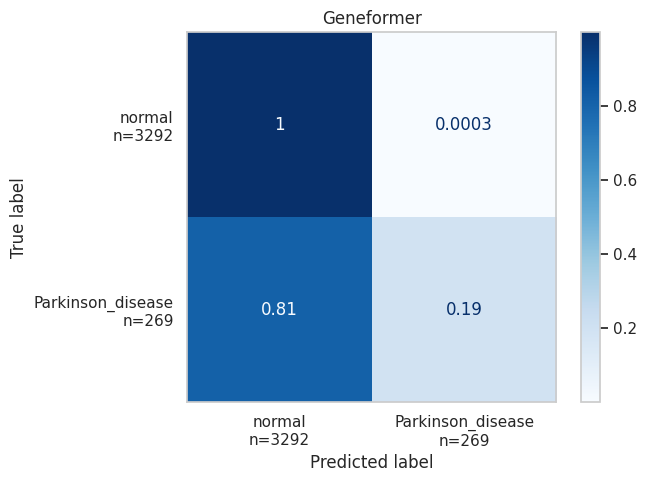

In [20]:
cc.plot_conf_mat(
        conf_mat_dict={"Geneformer": all_metrics_test["conf_matrix"]},
        output_directory=output_dir,
        output_prefix=output_prefix,
)

<Figure size 1500x1500 with 0 Axes>

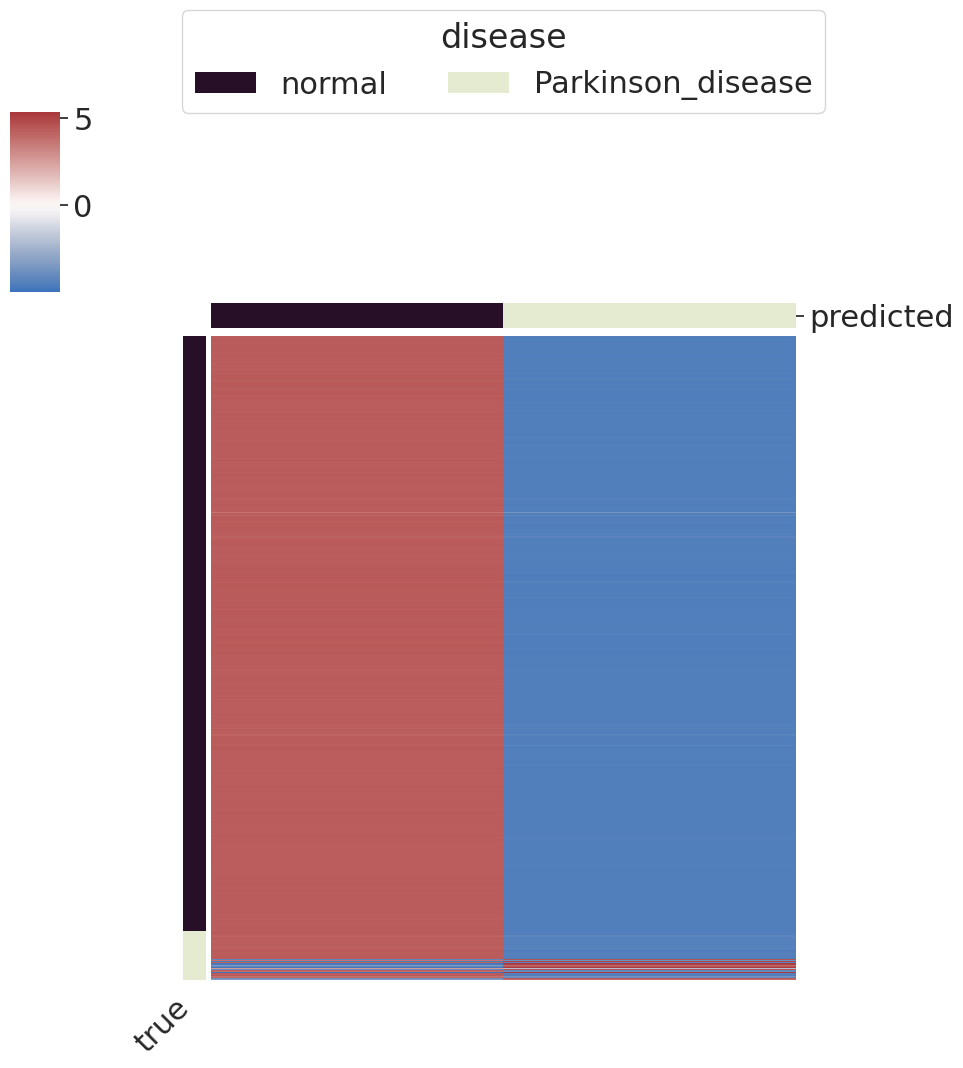

In [21]:
# cc.plot_predictions(
#     predictions_file=f"{output_dir}{output_prefix}_pred_dict.pkl",
#     id_class_dict_file = current_dict,
#     title="disease",
#     output_directory=output_dir,
#     output_prefix=output_prefix,
# )

cc.plot_predictions(
    predictions_file=f"{output_dir}/{output_prefix}_pred_dict.pkl",
    id_class_dict_file=current_dict,
    title="disease",
    output_directory=output_dir,
    output_prefix=output_prefix,
)